# GEOG 5160 6160 Lab 09

## Introduction

In the last lab, we looked at how to build and train convolutional neural networks for image classification. This lab will build from that by introducing a set of extensions from that basic model. These are:

- Using data generators to process and input image files
- Using data augmentation
- Using pretrained models

### Data

For this exercise, we'll again use the EuroSat benchmarking dataset from: https://zenodo.org/records/7711810:

> EuroSAT is a land use and land cover classification dataset. The dataset is based on Sentinel-2 satellite imagery covering 13 spectral bands and consists of 10 LULC classes with a total of 27,000 labeled and geo-referenced images. 

You should have a copy of these files from the previous lab, but if not, download the zip file *EuroSat_RGB.zip* from the class webpage, move it to a folder that is easy to find on your computer, and unzip it. 

Once you have unzipped the data, take a look in the *EuroSat_RGB* folder. This is already set up in the standard way for image classification, where all images for a given class are kept in a single folder for that class. The name of the folders can then used as the *label* for each image, and is what we will use. 

- EuroSat_RGB
  - AnnualCrop
  - Forest
  - HerbaceousVegetation
  - ...

## Data generators

In the previous exercise, we simply loaded all the image files into memory and converted them to **numpy** arrays for training and testing. This is fine for small sets of images, but can quickly become impractical with larger sets or when the images are larger. To help with this, **keras** has a set of helper functions. these can be set to only load a small number of images at a time (a *batch* of images). During each training *epoch* the function loads *batch_size* images in a batch, updates the model weights, then loads the next batch. In general, once each batch of images has been used, the set of validation images are then processed to get the validation metrics. 

**keras** has a set of these functions for different types of data (text, time series, images). Here, we'll use `image_dataset_from_directory`, which processes images from a named directory. This assumes that this directory contains a set of subdirectories (one per class of image). So the `train` directory will contain one directory called `AnnualCrop` with all the annual crop images, etc. What makes this a little more complex, is that the function is designed to work on separate folders of training, validation and testing images. So the actual folder format will look something like this:

```
- base_dir
  - train
    - AnnualCrop
    - Forest
    - HerbaceousVegetation
    - ...
  - valid
    - AnnualCrop
    - Forest
    - HerbaceousVegetation
    - ...
  - test
    - AnnualCrop
    - Forest
    - HerbaceousVegetation
    - ...
```

We'll now create this folder structure, shuffle the original image sets and copy them into this. Note that the code below is not the most efficient, but should hopefulyl be fairly transparent as to what is going on. Let's start by importing a set of libraries

In [1]:
import os
import glob
import random
import shutil
import pathlib
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

Next, we'll create the base folder structure. In the following code, `base_dir` is the name of the folder where you want to store the training, validation and testing images. `old_dir` is the folder that contains the original images that you downloaded. 

In [2]:
old_dir = "./datafiles/EuroSAT_RGB/EuroSAT_RGB/"

base_dir = "./datafiles/EuroSAT_RGB_class/"

## Training images
train_dir = os.path.join(base_dir, "train")
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

## Validation images
valid_dir = os.path.join(base_dir, "valid")
if not os.path.exists(valid_dir):
    os.makedirs(valid_dir)

## Testing images
test_dir = os.path.join(base_dir, "test")
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

Next, we'll make the individual class directories within each of `train`, `test` and `valid`:

In [3]:
lc_classes = os.listdir(old_dir)

for name in lc_classes:
    print(name)
    name_dir = os.path.join(train_dir, name)
    if not os.path.exists(name_dir):
        os.makedirs(name_dir)
    name_dir = os.path.join(valid_dir, name)
    if not os.path.exists(name_dir):
        os.makedirs(name_dir)
    name_dir = os.path.join(test_dir, name)
    if not os.path.exists(name_dir):
        os.makedirs(name_dir)

Forest
River
Highway
AnnualCrop
SeaLake
HerbaceousVegetation
Industrial
Residential
PermanentCrop
Pasture


And finally, we'll copy the files over. We'll use a split of 0.7 in training, and 0.15 in validation and testing. There's a fair amount going on here, but in short, for each land cover class we:

- Get a list of the images in the original folder
- Shuffle this list to get a random order
- Create a new list of training images (the first 70%), validation (the next 15%) and testing (the last 15%)
- Remove any existing files in the class subfolder for `train`, `valid` and `test`
- Copy over the randomly sort files

Note that this might take a couple of minutes to run (it is trying to process about 25000 images). 

In [4]:
train_ratio = 0.7
valid_ratio = 0.15

for name in lc_classes:
    print(name)
    input_dir = os.path.join(old_dir, name) ## Input directory of images
    image_files = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))] ## Get list of files
    random.shuffle(image_files) ## Shuffle
    nfiles = len(image_files)
    print(f'Total: {nfiles}')

    train_count = int(nfiles * train_ratio)
    valid_count = int(nfiles * valid_ratio)
    print(f'Training: {train_count}; Validation: {valid_count}; Testing: {nfiles - (train_count + valid_count)}')

    train_images = image_files[:train_count]
    val_images = image_files[train_count:train_count + valid_count]
    test_images = image_files[train_count + valid_count:]

    valid_out = os.path.join(valid_dir, name)
    test_out = os.path.join(test_dir, name)

    ## Remove existing files
    train_out = os.path.join(train_dir, name)
    files = glob.glob(train_out + '/*')
    for f in files:
        os.remove(f)

    valid_out = os.path.join(valid_dir, name)
    files = glob.glob(valid_out + '/*')
    for f in files:
        os.remove(f)

    test_out = os.path.join(test_dir, name)
    files = glob.glob(test_out + '/*')
    for f in files:
        os.remove(f)

    ## Add new files
    for img in train_images:
        shutil.copy(os.path.join(input_dir, img), os.path.join(train_out, img))
    for img in val_images:
        shutil.copy(os.path.join(input_dir, img), os.path.join(valid_out, img))
    for img in test_images:
         shutil.copy(os.path.join(input_dir, img), os.path.join(test_out, img))

Forest
Total: 3000
Training: 2100; Validation: 450; Testing: 450
River
Total: 2500
Training: 1750; Validation: 375; Testing: 375
Highway
Total: 2500
Training: 1750; Validation: 375; Testing: 375
AnnualCrop
Total: 3000
Training: 2100; Validation: 450; Testing: 450
SeaLake
Total: 3000
Training: 2100; Validation: 450; Testing: 450
HerbaceousVegetation
Total: 3000
Training: 2100; Validation: 450; Testing: 450
Industrial
Total: 2500
Training: 1750; Validation: 375; Testing: 375
Residential
Total: 3000
Training: 2100; Validation: 450; Testing: 450
PermanentCrop
Total: 2500
Training: 1750; Validation: 375; Testing: 375
Pasture
Total: 2000
Training: 1400; Validation: 300; Testing: 300


We can now set up the data generator using `image_dataset_from_directory`. First, let's fix the base directory, plus image size and number of channels, and the batch size (the number of images to be loaded at any one time)

In [5]:
new_base_dir = pathlib.Path("./datafiles/EuroSAT_RGB_class")

image_width = 64
image_height = 64
num_channels = 3

batch_size = 32

Now, we'll set up an generator for the training images. This takes as arguments

- The top level folder storing the class folders
- The image size
- The batch size

There are a number of other arguments to this function, including whether to shuffle the images between epochs (default `True`), and whether to infer the class names from the subfolder names or from a list (default `inferred`). When you run this, it should print both the number of images and classes it found in that directory. If either of these numbers is 0, please check your file path


In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(image_width, image_height),
    batch_size=batch_size)


Found 18900 files belonging to 10 classes.


Now, we can set up separate generators for the validation and training sets:

In [7]:
validation_dataset = image_dataset_from_directory(
    new_base_dir / "valid",
    image_size=(image_width, image_height),
    batch_size=batch_size)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(image_width, image_height),
    batch_size=batch_size)

Found 4050 files belonging to 10 classes.
Found 4050 files belonging to 10 classes.


The `dataset` objects made can now be used to generate sets of data. Just as an example, the following code would iterate over all batches of training data and print their shapes. Note that each batch of features is `(batch_size, image_width, image_height, num_channels)` and each batch of labels is `batch_size`.

In [8]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 64, 64, 3)
labels batch shape: (32,)


## CNN with data generator

We'll now go ahead and build a model that can be trained using the data generator. In the interest of time in this class, we'll keep this model simple, with only two convolutional layers, and two max-pooling steps. (Feel free to experiment with this by adding more convolutions or dense layers after the `Flatten` layer).

We'll also use a different syntax to build the model. This is **keras** functional API, which allows for more flexible model building. If you look at the code below, you should see that each layer is added as a single function call, rather than putting everything within a `Sequential` model as we did previously. This can help in diagnosing problems (when a single layer causes a error), as well as allowing different model architechtures. A couple of other things to note:

- We start with an `Input` layer, and gradually add other layers to this. Once these are defined, we connect this to an output `Dense` layer, and then use the `Model` function to combine everything together
- We include a `Rescaling` layer to convert between the original pixel values ([0-255]) and a standardized range of [0-1]

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(image_width, image_height, num_channels))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       401,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,162 (1.61 MB)

 Trainable params: 421,162 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Now we'll define the loss, optimizer and performance metric. The only change here is that we will use the slightly simpler `RMSprop` as the optimizer

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=["accuracy"])

Before training, we'll define a *callback*. This is one of a set of functions that are run at specific times during the training. There are a number of these that can carry out different operations (and you can write your own). Here, we'll use `ModelCheckpoint`. This will save the state of the model (i.e. the weights) at each step. To avoid overwriting the file if the model starts to overfit, we specify that the update should only be made if the current validation accuracy is better than the previously saved one. 

As deep learning models can take quite a long time to train, it's worth getting used to saving them to file so that you can reuse them at a later point without costly retraining.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="model1.keras",
        save_best_only=True,
        monitor="val_loss")
]

And finally, we train the model. We'll only train it for 10 epochs here to keep the computation time down, but in practice, this would likely need several more.

In [13]:
history = model.fit(
    train_dataset,
    # epochs=30,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.2586 - loss: 2.0194 - val_accuracy: 0.4185 - val_loss: 1.5872
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.4592 - loss: 1.4930 - val_accuracy: 0.5281 - val_loss: 1.3991
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5169 - loss: 1.3594 - val_accuracy: 0.4454 - val_loss: 1.4230
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5350 - loss: 1.2666 - val_accuracy: 0.5622 - val_loss: 1.1985
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5721 - loss: 1.1802 - val_accuracy: 0.5911 - val_loss: 1.1154
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6026 - loss: 1.1057 - val_accuracy: 0.5963 - val_loss: 1.0840
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6279 - loss: 1.0472 - val_accuracy: 0.6365 - val_loss: 1.0259
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6468 - loss: 1.0027 - 

Let's plot the accuracy and loss curves

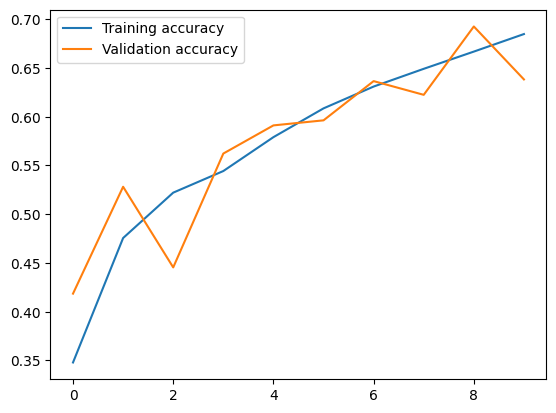

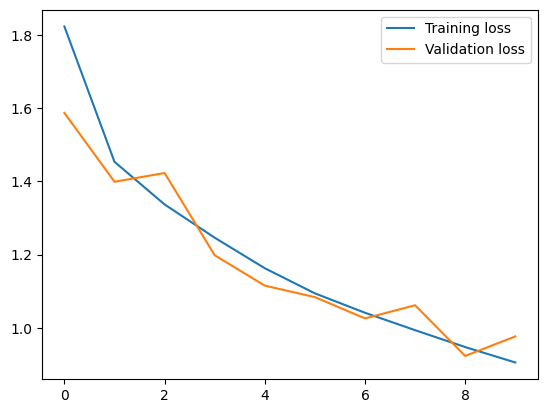

In [14]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.figure()
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

Next, we'll evaluate the model using the test images. To demonstrate the use of the save model file, we'll load that and use the resulting object to evaluate. You should get an accuracy of between 0.7 and 0.8. This is lower than the previous model we built, as the current one is both simpler and has only been trained for a short period. 

In [ ]:
test_model = keras.models.load_model("model1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6899 - loss: 0.9126
Test accuracy: 0.691


## Using data augmentation

The most successful CNNs are generally trained on hundreds of thousands or millions of images. So while we have around 19000 images to train from, this remains a fairly small dataset. One approach to improve the predictive skill of models trained 'from scratch' with smaller data is to use *data augmentation*. In this approach, we randomly manipulate each training image at each epoch through rotations, zooming, translation, flipping, etc. This is trying to represent the concept that if a set of people all took an image of the same object, each image would be slightly different as some people would be closer/further away, shorter or taller etc. 

Rather than trying to do this by hand, **keras** has a set of layers that will peform random augmentation (defining these as layers makes it easy to incorporate them in a CNN as we will see). To illustrate this, we'll create a new model that represents the data augmentation step. This will have a randomly flip (both horizontal and vertical), a random rotation by about 10% (left and right) and a random zoom of up to 20%

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip(),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

We can now extract a random training image (`train_dataset.take(1)`) and pass it through the augmentation model to show the results. Note that your image and changes will be different. You can also re-run this multiple times to see different images

2025-03-28 19:43:20.402144: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


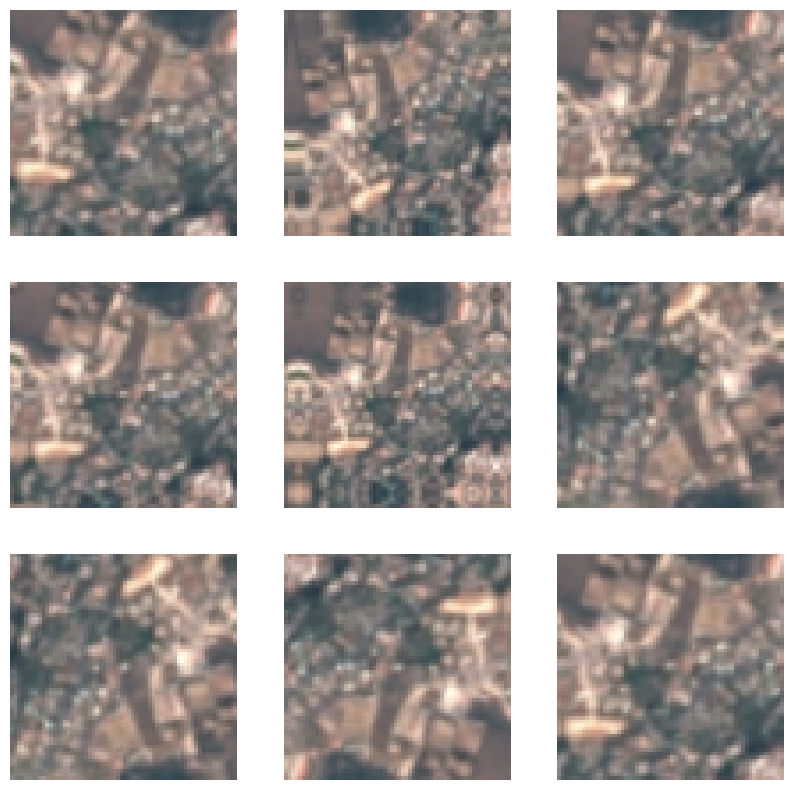

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

To incorporate that into a CNN model, all we have to do is include this set of layers in the model we build, between the input and first convolution layer. As augmentation effectively increases the correlation between images, we'll also add a drop out later after flattening to limit the effect of this

In [18]:
inputs = keras.Input(shape=(image_width, image_height, num_channels))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])

Again, we'll train with a checkpoint to save the best model. Augmentation usually requires a longer period of training (we'll run for 10 epochs here)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="model2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
#     epochs=100,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.2830 - loss: 1.9033 - val_accuracy: 0.5973 - val_loss: 1.2511
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.4880 - loss: 1.4214 - val_accuracy: 0.6027 - val_loss: 1.1692
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5682 - loss: 1.2219 - val_accuracy: 0.7319 - val_loss: 0.7928
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6135 - loss: 1.1023 - val_accuracy: 0.6805 - val_loss: 0.8764
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6517 - loss: 1.0240 - val_accuracy: 0.6849 - val_loss: 0.8978
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6704 - loss: 0.9545 - val_accuracy: 0.6970 - val_loss: 0.9094
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6766 - loss: 0.9339 - val_accuracy: 0.7047 - val_loss: 0.8750
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.6940 - loss: 0.9030 - 

And as before, we'll load the model and evaluate using the test set. You should see a small improvement in the accuracy (and running this for a longer set of iterations would improve this further). 

In [ ]:
test_model = keras.models.load_model(
    "model2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7312 - loss: 0.7469
Test accuracy: 0.728


## Using a pretrained model

An alternative approach for working with small image datasets is to use pretrained CNNs. These are generally CNNs that have been trained on a much larger and more varied set of images. To understand how (and why) this might work, it helps to remember that CNNs are considered to have two sections:

- A feature extractor (the convolution and pooling layers) - also known as the 'convolutional base'
- A classifier (the set of densely connected layers and the output)

When we use pretrained models, we try to leverage information contained in the convolutional base. For large models, trained on large data, the idea is that some of the image features that were learned are generic - i.e. they can occur in some way in multiple classes of images. 

> If this original data-set is large enough and general enough, the spatial hierarchy of features learned by the pretrained model can effectively act as a generic model of the visual world, and hence, its features can prove useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task (Chollet)

Or to put it another way, if the model has learned how to look at the world and recognize general features in images, we should be able to recombine these to learn new types or classes of image. 

### Feature extraction

As a first attempt at this, we'll use a pretrained model simply as a feature extractor. In practice, this means pushing our EuroSAT images through the pretrained convolutional base and saving the outputs. We'll then use these as *inputs* to train a new classifier model

> Why reuse only the convolutional base? Could we reuse the densely connected classifier as well? In general, doing so should be avoided. The reason is that the representations learned by the convolutional base are likely to be more generic and, therefore, more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which are likely to be useful regardless of the computer vision problem at hand. But the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained (Chollet)

Here, we'll use the VGG16 model. This is a model developed by the University of Oxford. It has 16 layers, and was trained on the ImageNet dataset which comprises around 14 million images from 1000 different classes. **keras** has a useful helper function to acquire this model (and a few others as well). A much broader range of pretrained models can be found on the Hugging Face website (https://huggingface.co/).

Let's download this and set it up. Note that we specify the weights (based on the dataset used to train it originally), whether or not to include the classifier (`include_top=False`) and the expected input shape of the images we will be using this with

In [21]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(image_width, image_height, num_channels))

Let's take a look at the model. Note this is a much higher number of weights than anything we've looked at so fat (~14 million). Note also that there are no dense or output layers

In [22]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

So how do we use this? We'll create a function that iterates across every image we have in training, validation and testing. This will take the image and run it through the VGGNet convolutional base, where each image will be transformed using the learned set of convolutions (and pooling). The transformed images are save as `all_features` and the corresponding labels are also saved.

In [23]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

Now let's run this to convert all images. Note that this will take a few minutes to run.

In [24]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-03-28 19:47:49.369484: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-03-28 19:48:35.252540: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Once we have the set of transformed images, we can create a new classifier. We'll just reuse the same set of layers as in the previous model (`Flatten` -> `Dense` -> `Dropout` -> `Output`).

In [25]:
inputs = keras.Input(shape=(2, 2, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(64)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])

In [26]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,786 (514.79 KB)

 Trainable params: 131,786 (514.79 KB)

 Non-trainable params: 0 (0.00 B)

And train it! One of the big advantages of this approach is that the model is substantially smaller (no convolutions) and so quicker to train

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="model3.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7230 - loss: 4.5315 - val_accuracy: 0.8921 - val_loss: 1.3918
Epoch 2/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - accuracy: 0.8600 - loss: 1.7486 - val_accuracy: 0.9042 - val_loss: 1.1900
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8878 - loss: 1.1157 - val_accuracy: 0.9012 - val_loss: 1.0371
Epoch 4/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.8965 - loss: 0.8600 - val_accuracy: 0.9002 - val_loss: 0.8164
Epoch 5/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.9051 - loss: 0.6170 - val_accuracy: 0.9000 - val_loss: 0.6900
Epoch 6/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9103 - loss: 0.4969 - val_accuracy: 0.9047 - val_loss: 0.6028
Epoch 7/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9139 - loss: 0.4124 - val_accuracy: 0.9042 - val_loss: 0.5460
Epoch 8/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.9210 - loss: 0.3354 - val_

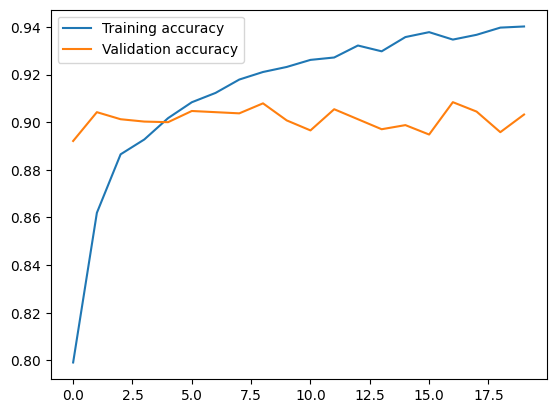

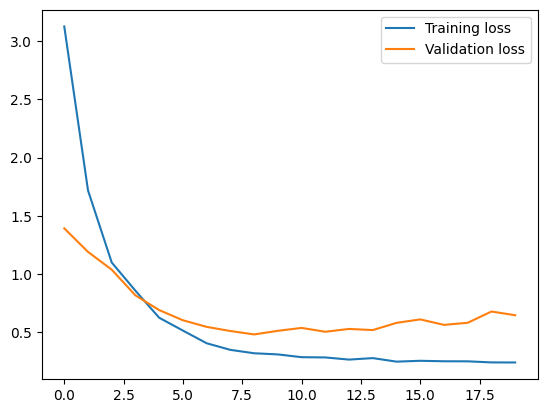

In [28]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.figure()
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

And we can evaluate on the training set using the *extracted* test dataset. This now should show a substantial improvement over the previous models, with an accuracy of over 90%. 

In [ ]:
test_model = keras.models.load_model(
    "model3.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.9172 - loss: 0.3815
Test accuracy: 0.915


### Feature extraction with data augmentation

In the previous model, we separated the feature extraction and classifier into two separate steps. This prevents us from using data augmentation, as we only 'extract' each image once. If you want to combine both these approaches, it is possible to create a new model that incorporates:

- The augmentation layer(s)
- The convolutional base
- The new trainable classifier

And we'll demonstrate this here. First, we re-instantiate the VGGNet model. We then set the argument `trainable = False`. This 'freezes' all the existing weights so that they are not updated during training.

**Note that this model will take a **

In [30]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

If you now look at the summary of this model, you should see that the number of trainable parameters (at the bottom) is now 0; in other words, we do not update any of these while training with the new data

In [31]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

We then make the augmentation layer (we could simply reuse the one from above, this is just here as a reminder). And finally add the convolutional base, the augmentation and a new classifer together into a new CNN classifiier. 

In [32]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip(),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])

The code to run this is given below. This takes a fair amount of time to run (roughly 20 min on my laptop), as we are now obtaining batches of images, extracting the features using the previous model (`vgg16.preprocess_input`), passing this through a classifier and then doing all the usual updating of weights.

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 121s 204ms/step - accuracy: 0.6820 - loss: 4.5068 - val_accuracy: 0.8800 - val_loss: 1.5636
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 119s 201ms/step - accuracy: 0.8054 - loss: 2.3344 - val_accuracy: 0.8807 - val_loss: 1.1475
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 123s 208ms/step - accuracy: 0.8227 - loss: 1.3845 - val_accuracy: 0.8805 - val_loss: 0.8248
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 119s 202ms/step - accuracy: 0.8298 - loss: 0.9227 - val_accuracy: 0.8709 - val_loss: 0.6678
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 122s 206ms/step - accuracy: 0.8399 - loss: 0.6888 - val_accuracy: 0.8921 - val_loss: 0.4117
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 126s 214ms/step - accuracy: 0.8478 - loss: 0.5320 - val_accuracy: 0.8867 - val_loss: 0.4444
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 125s 212ms/step - accuracy: 0.8490 - loss: 0.5173 - val_accuracy: 0.8998 - val_loss: 0.3680
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 122s 207ms/step - accuracy: 0.8613 -

Testing this shows a similar improvement to the previous model (>0.9). Note though, that in the previous model we had to extract all the features into memory before training, whereas here we only load the data we need for a single batch. This may be important when working with much larger datasets

In [34]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.9040 - loss: 0.3253
Test accuracy: 0.906


### Fine-tuning

Another potential issue with using pre-trained models arises when there is a big difference between the original classification task that they were trained on, and the new task we are using this for. Here, we are using a model (VGGNet) trained on a set of images (ImageNet) that largely contain objects (animals, vehicles, etc; the full list is here: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/). And we are using this to perform land cover classification. 

Why is this an issue? The effect of pooling in the model means that the first convolutional layers represent very generic shapes and fearures (such as visual edges, colors, and textures), where as later convolutions find combinations of these that represent more complex objects in the image (a cat's eye for example). In this case, an alternative approach is to fine tune the pre-trained model. In practice, this means keeping or freezing the weights on the first set of (generic) layers, and relearning the weights for later (specific) layers so that they better match the images you are working with. 

So let's see how this works. Above, we used an argument (`trainable`) to freeze all the layers in the convolutional base. We can reset this to true, then freeze all but the top four layers with the following code

In [35]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

If we now look at the model, you'll see there are about 7 million trainable parameters, about half as many as the original model, but substantial more than when we used this for simple feature extraction.

In [36]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64, 3) │          0 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 64, 64)    │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 64, 64)    │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 64, 64)    │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 64, 64, 3) │          0 │ get_item[0][0],   │
│                     │                   │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64, 3) │          0 │ stack[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 2, 2, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 2048)      │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │    131,136 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │        650 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,978,262 (57.14 MB)

 Trainable params: 7,211,210 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 131,788 (514.80 KB)

We'll now retrain this. We'll reuse the same classifier and augmentation layer as above. As a result, we simply need to recompile the model to take account of the changes to the convolutional base

In [37]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])

In [38]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64, 3) │          0 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 64, 64)    │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 64, 64)    │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 64, 64)    │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 64, 64, 3) │          0 │ get_item[0][0],   │
│                     │                   │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64, 3) │          0 │ stack[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 2, 2, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 2048)      │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │    131,136 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │        650 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,846,474 (56.63 MB)

 Trainable params: 7,211,210 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

And finally, fit this model. This will take substantially longer than the other models in this lab as we are trying to learn a much higher number of weights (this took around 3 minutes per epoch on my laptop). The code is included here, but you may want to skip this step unless you have access to a GPU. 

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 158s 266ms/step - accuracy: 0.4063 - loss: 17.7138 - val_accuracy: 0.8568 - val_loss: 0.7660
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 160s 271ms/step - accuracy: 0.8560 - loss: 0.5697 - val_accuracy: 0.9158 - val_loss: 0.3967
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 158s 267ms/step - accuracy: 0.8796 - loss: 0.4759 - val_accuracy: 0.8943 - val_loss: 0.5761
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 159s 269ms/step - accuracy: 0.8924 - loss: 0.4405 - val_accuracy: 0.9007 - val_loss: 0.5057
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 165s 279ms/step - accuracy: 0.9011 - loss: 0.4289 - val_accuracy: 0.9067 - val_loss: 0.5770
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 159s 270ms/step - accuracy: 0.9001 - loss: 0.4164 - val_accuracy: 0.9299 - val_loss: 0.3499
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 159s 269ms/step - accuracy: 0.9075 - loss: 0.3917 - val_accuracy: 0.8230 - val_loss: 0.9656
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 165s 279ms/step - accuracy: 0.9082 

If we evaluate this, you should see another small improvement in the model (to over 0.93). Remember that the first model we built had an accuracy of around 0.7, and this should give you an indication of how much these models can be improved *without* requiring new data. 

In [40]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.9373 - loss: 0.3134
Test accuracy: 0.933
